In [6]:
%run ./src.ipynb

382, 48, 61, participants in Train, Validation, and Test sets
Processing fold 1...
Class weights:  {0: 0.5843134573304157, 1: 3.465125709651257}
Epoch 1/60
268/268 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - AUC: 0.5071 - accuracy: 0.5526 - loss: nan - val_AUC: 0.5000 - val_accuracy: 0.8616 - val_loss: nan - learning_rate: 2.0000e-04
Epoch 2/60
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - AUC: 0.5000 - accuracy: 0.8626 - loss: nan - val_AUC: 0.5000 - val_accuracy: 0.8616 - val_loss: nan - learning_rate: 2.0000e-04
Epoch 3/60
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - AUC: 0.5000 - accuracy: 0.8520 - loss: nan - val_AUC: 0.5000 - val_accuracy: 0.8616 - val_loss: nan - learning_rate: 2.0000e-04
Epoch 4/60
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - AUC: 0.5000 - accuracy: 0.8553 - loss: nan - val_AUC: 0.5000 - val_accuracy: 0.8616 - val_loss: nan - learning_rate: 2.0000e-04
Epoch 5/60
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - AUC: 0.5000 - accuracy: 0.8567 - loss: nan - val_AUC: 0.5000 - 

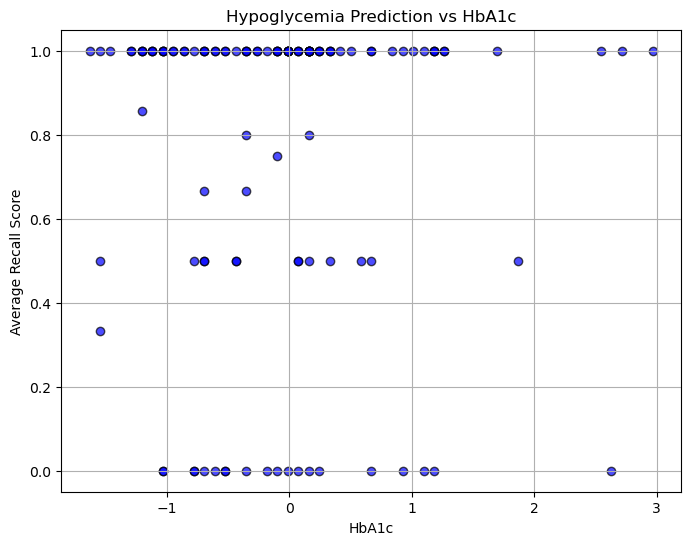

Plot saved at: /home/ma98/results/holdoutResultsFull/Night2/loss_auc_accuracy_plot.png


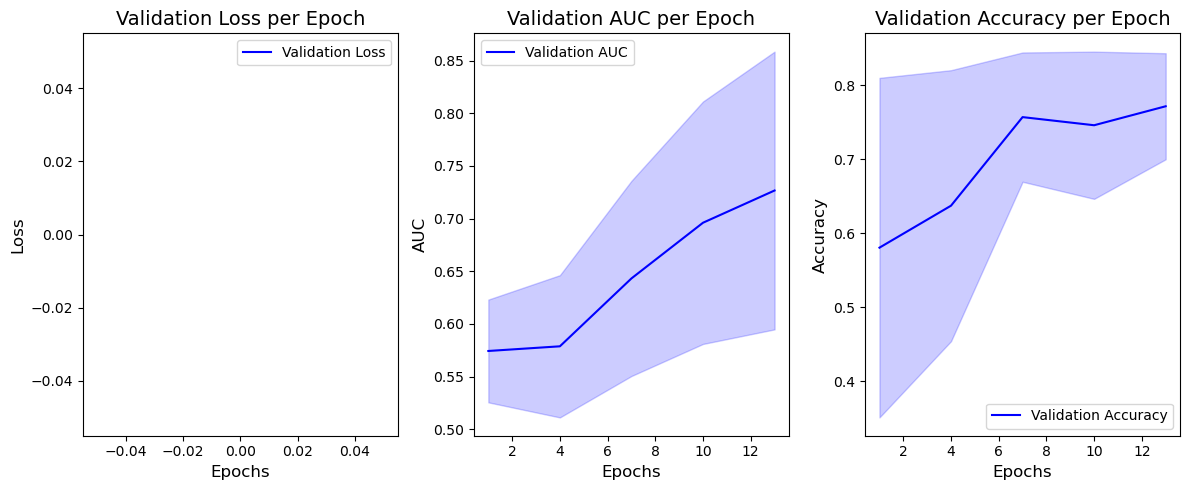

In [8]:
# learning_rate=2e-4
# Resampled
# checkpoint
# monitor='val_loss'
# 10 split
# batch 32

%matplotlib inline

matrix_shape0 = 288
dailyshape = 327
individualshape = 324
folder_name = "/home/__/results/holdoutResultsFull/Night"
configure_gpu()

# Perform K-Fold Cross-Validation with Transfer Learning
source_results, target_results = cross_validation_holdout_analysis(label_name="hypo_night",num_splits=10, num_epochs=60,batch_s=32, num_patience=15, monitored='val_loss',threshold=0.32)
gc.collect()


# Save results for comparison
saved_results = "/home/__/results/holdoutResultsFull/Night/source_results.npy"
np.save(saved_results, source_results)
# Save results for comparison
saved_results = "/home/__/results/holdoutResultsFull/Night/target_results.npy"
np.save(saved_results, target_results)



382, 48, 61, participants in Train, Validation, and Test sets
Processing fold 1...
Class weights:  {0: 0.5830723137682147, 1: 3.509426229508197}
Epoch 1/60
268/268 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - AUC: 0.4903 - accuracy: 0.5404 - loss: 3.6676 - val_AUC: 0.6172 - val_accuracy: 0.2632 - val_loss: 3.0026 - learning_rate: 2.0000e-04
Epoch 2/60
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - AUC: 0.5232 - accuracy: 0.5040 - loss: 3.0371 - val_AUC: 0.7415 - val_accuracy: 0.4925 - val_loss: 2.8030 - learning_rate: 2.0000e-04
Epoch 3/60
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - AUC: 0.5234 - accuracy: 0.5003 - loss: 2.8294 - val_AUC: 0.7593 - val_accuracy: 0.6241 - val_loss: 2.6108 - learning_rate: 2.0000e-04
Epoch 4/60
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - AUC: 0.6045 - accuracy: 0.5827 - loss: 2.6057 - val_AUC: 0.8383 - val_accuracy: 0.5583 - val_loss: 2.4097 - learning_rate: 2.0000e-04
Epoch 5/60
268/268 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - AUC: 0.7322 - accuracy: 0.6315 - loss: 

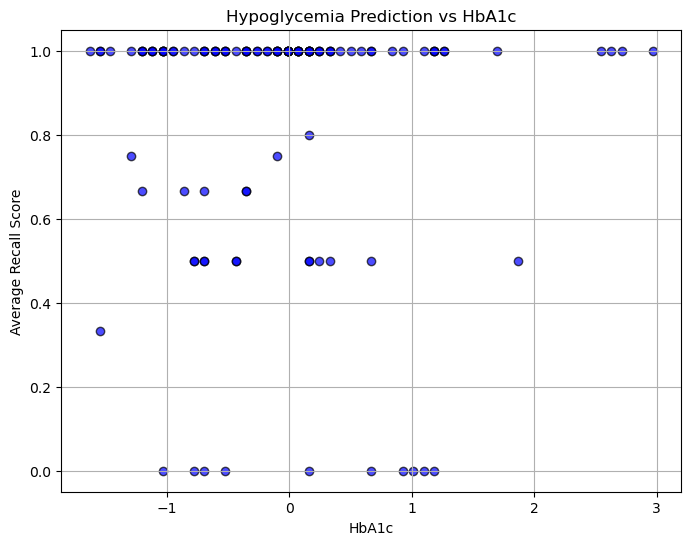

Plot saved at: /home/ma98/results/holdoutResultsFull/Night2/loss_auc_accuracy_plot.png


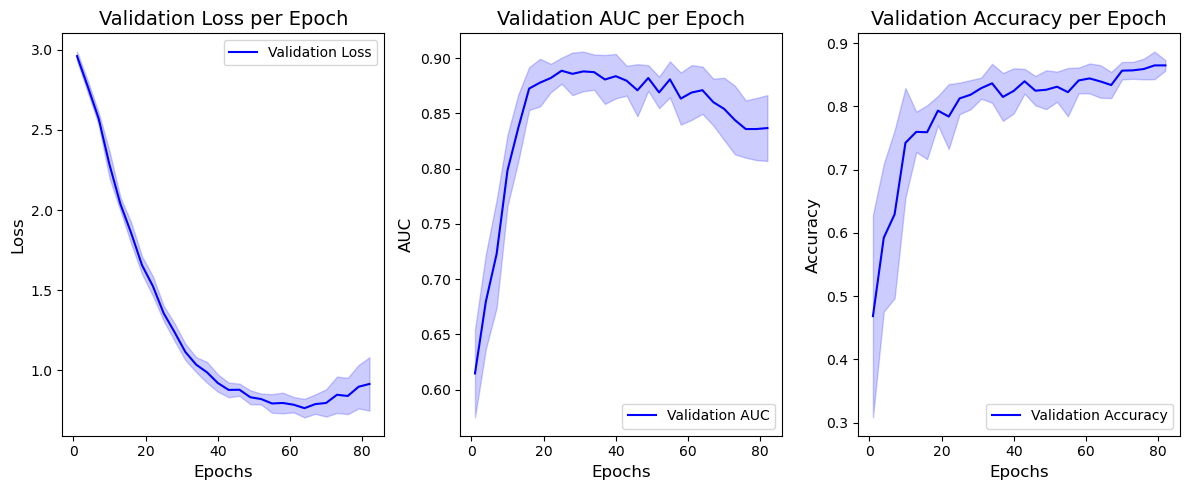

In [4]:
# learning_rate=2e-4
# Resampled
# checkpoint
# monitor='val_loss'
# 10 split
# batch 32

%matplotlib inline

matrix_shape0 = 288
dailyshape = 327
individualshape = 324
folder_name = "/home/__/results/holdoutResultsFull/Night2"
configure_gpu()

# Perform K-Fold Cross-Validation with Transfer Learning
source_results, target_results = cross_validation_holdout_analysis(label_name="hypo_night",num_splits=10, num_epochs=60,batch_s=32, num_patience=20, monitored='val_loss',threshold=0.32)
gc.collect()


# Save results for comparison
saved_results = "/home/__/results/holdoutResultsFull/Night2/source_results.npy"
np.save(saved_results, source_results)
# Save results for comparison
saved_results = "/home/__/results/holdoutResultsFull/Night2/target_results.npy"
np.save(saved_results, target_results)



In [ ]:
# learning_rate=2e-4
# Resampled
# checkpoint
# monitor='val_loss'
# 10 split
# batch 32

%matplotlib inline

matrix_shape0 = 288
dailyshape = 327
individualshape = 324
folder_name = "/home/__/results/holdoutResultsFull/Night"
configure_gpu()

# Perform K-Fold Cross-Validation with Transfer Learning
source_results, target_results = cross_validation_holdout_analysis(label_name="hypo_night",num_splits=10, num_epochs=60,batch_s=32, num_patience=20, monitored='val_loss',threshold=0.32)
gc.collect()


# Save results for comparison
saved_results = "/home/__/results/holdoutResultsFull/Night/source_results.npy"
np.save(saved_results, source_results)
# Save results for comparison
saved_results = "/home/__/results/holdoutResultsFull/Night/target_results.npy"
np.save(saved_results, target_results)

